In [5]:
!nvidia-smi

Thu Sep 25 17:32:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Phần B

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import os
import torch
import torch.nn.functional as F
import math
import cv2 # Sử dụng cv2 để đọc ảnh, vì plt.imread có thể không đọc được một số định dạng jpg

# --- Thiết lập thiết bị (CPU/GPU) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [30]:
# ==========================================================
# CÁC HÀM XỬ LÝ
# ==========================================================

def LoG_function(sigma):
    """Tạo bộ lọc Laplacian of Gaussian (LoG)"""
    size = int(2 * math.ceil(3 * sigma) + 1)
    rad = size // 2
    x = torch.arange(-rad, rad + 1, dtype=torch.float32, device=device)
    y = torch.arange(-rad, rad + 1, dtype=torch.float32, device=device)
    x, y = torch.meshgrid(x, y, indexing='ij')
    s2 = sigma ** 2
    exp = torch.exp(-(x**2 + y**2) / (2 * s2))
    log = (-2 * s2 + (x**2 + y**2)) * exp * (1 / (2 * math.pi * s2**2))
    return log

def detectByLoG(img, logKernel):
    """Áp dụng bộ lọc LoG lên ảnh"""
    img = img.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    logKernel = logKernel.unsqueeze(0).unsqueeze(0)  # (1,1,k,k)
    return F.conv2d(img, logKernel, padding=(logKernel.shape[2]//2, logKernel.shape[3]//2)).squeeze()

def create_log_pyramid(img, initSigma=1.0, no_scale_lv=9, CONSTANT_K=1.3):
    """Tạo kim tự tháp ảnh LoG ở nhiều tỉ lệ"""
    pyramid = []
    sigma = initSigma
    img_tensor = torch.from_numpy(img).float().to(device)
    for i in range(no_scale_lv):
        logKernel = LoG_function(sigma)
        logImg = detectByLoG(img_tensor, logKernel)
        logImg = logImg ** 2  # Bình phương để giá trị luôn dương
        # Chuẩn hóa về khoảng [0, 1]
        if logImg.max() > 0:
            logImg = (logImg - logImg.min()) / (logImg.max() - logImg.min())
        # Thêm padding để xử lý vùng biên
        logImg = F.pad(logImg, (1, 1, 1, 1), mode='constant', value=0)
        pyramid.append(logImg)
        sigma *= CONSTANT_K
    return pyramid



def build_gaussian_pyramid(img, num_octaves=4, s=3, sigma0=1.6):
    pyr = []
    k = 2 ** (1.0 / s)
    for o in range(num_octaves):
        octave = []
        for i in range(s+3):
            sigma = sigma0 * (k**i) * (2**o)
            blur = cv2.GaussianBlur(img, (0,0), sigma)
            octave.append(blur)   # <-- không để [blur]
        pyr.append(octave)
    return pyr
def build_dog_pyramid(gauss_pyr):
    dog_pyr = []
    for octave_imgs in gauss_pyr:
        dogs = [octave_imgs[i] - octave_imgs[i-1] for i in range(1, len(octave_imgs))]
        dog_pyr.append(dogs)
    return dog_pyr

initSigma = 1.0 #(basis 1 = 1)
no_scale_lv = 9
def detectBlobByLoG(img, threshold=0.03):
    H, W = img.shape
    keypoints = []
    
    # Tạo Gaussian pyramid
    gauss_pyr = build_gaussian_pyramid(img)
    dog_pyr = build_dog_pyramid(gauss_pyr)

    # Lặp qua từng octave
    for octave in range(1, len(dog_pyr)-1):
        prev_img = dog_pyr[octave-1][1]
        cur_img  = dog_pyr[octave][1]
        next_img = dog_pyr[octave+1][1]

        iH, iW = cur_img.shape

        for x in range(1, iH-1):
            for y in range(1, iW-1):

                val = cur_img[x, y]

                # kiểm tra cực trị 3D
                if (np.all(val >= cur_img[x-1:x+2, y-1:y+2]) and
                    np.all(val >= prev_img[x-1:x+2, y-1:y+2]) and
                    np.all(val >= next_img[x-1:x+2, y-1:y+2]) and
                    val > threshold):

                    keypoints.append(cv2.KeyPoint(float(y), float(x), 3))

    return keypoints


def plotBlob(img, keypoints, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img, cmap='gray')
    for kp in keypoints:
        x, y = kp.pt      # tọa độ (float)
        sigma = kp.size   # kích thước (size ~ sigma)
        rad = sigma * np.sqrt(2)
        circle = plt.Circle((x, y), rad, color='red', linewidth=1.5, fill=False)
        ax.add_patch(circle)
    ax.set_title(title)
    plt.show()


Tìm thấy 149 keypoints trong ảnh 1.
Tìm thấy 2237 keypoints trong ảnh 2.


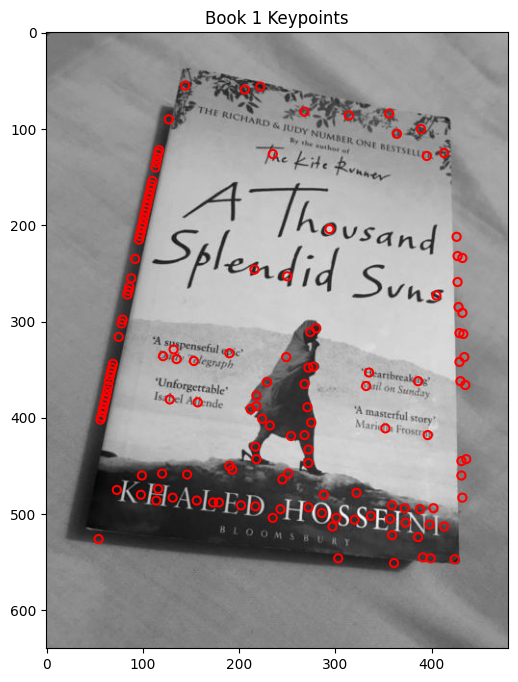

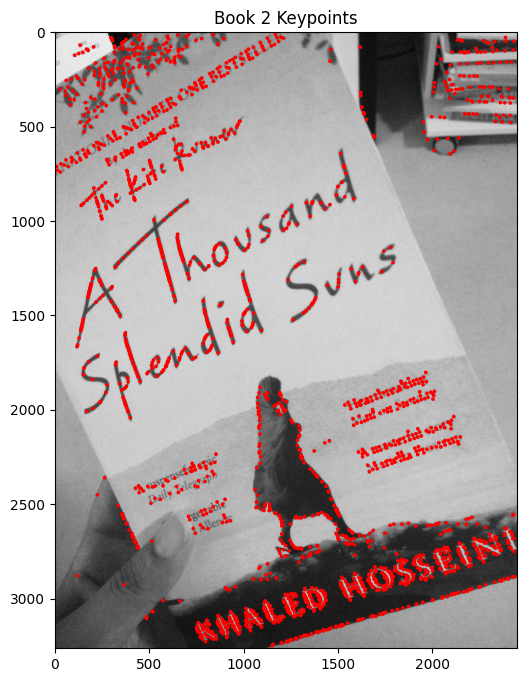


Tìm thấy 75 cặp điểm khớp.


In [ ]:
# ==========================================================
# CHƯƠNG TRÌNH CHÍNH
# ==========================================================

# --- Đọc và xử lý ảnh ---
# Giả sử ảnh nằm trong thư mục 'img_data' cùng cấp với file mã nguồn
# Bạn hãy thay đổi đường dẫn này cho phù hợp
try:
    img1_path = '/kaggle/input/img-example/book1.jpg'
    img2_path = '/kaggle/input/img-example/book2.jpg'
    
    img1_bgr = cv2.imread(img1_path)
    img2_bgr = cv2.imread(img2_path)

    if img1_bgr is None or img2_bgr is None:
        raise FileNotFoundError
        
    # Chuyển sang ảnh xám
    img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)
    
    # Chuẩn hóa giá trị pixel về [0, 1]
    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file ảnh. Vui lòng kiểm tra lại đường dẫn '{img1_path}' và '{img2_path}'.")
    exit()


# --- Tìm keypoints ---
# Giảm ngưỡng `threshold` để thuật toán nhạy hơn, tìm được nhiều điểm hơn
keypoints1 = detectBlobByLoG(img1, threshold=0.01)
keypoints2 = detectBlobByLoG(img2, threshold=0.01)

print(f"Tìm thấy {len(keypoints1)} keypoints trong ảnh 1.")
print(f"Tìm thấy {len(keypoints2)} keypoints trong ảnh 2.")

# --- Hiển thị keypoints trên từng ảnh ---
plotBlob(img1, keypoints1, "Book 1 Keypoints")
plotBlob(img2, keypoints2, "Book 2 Keypoints")

# --- So khớp và vẽ đường nối (ĐÃ SỬA LỖI) ---
# Chỉ thực hiện so khớp nếu cả hai ảnh đều có keypoints
if keypoints1 and keypoints2:
    # Chuyển đổi keypoints thành mảng numpy (x, y)
    pts1 = np.array([kp.pt for kp in keypoints1], dtype=np.float32)
    pts2 = np.array([kp.pt for kp in keypoints2], dtype=np.float32)


    # Sử dụng KDTree để tìm các điểm gần nhất một cách hiệu quả
    tree2 = KDTree(pts2)


    import cv2

    # Resize img2 về cùng chiều cao với img1
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    scale = h1 / h2
    img2_resized = cv2.resize(img2, (int(w2 * scale), h1))
    
    # Ghép ngang
    img_combined = np.hstack((img1, img2_resized))
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(img_combined, cmap='gray')
    
    matches_count = 0
    # Với mỗi điểm ở ảnh 1, tìm điểm gần nhất ở ảnh 2
    for pt1 in pts1:
        dist, idx = tree2.query(pt1)
        
        # Chỉ coi là một cặp khớp nếu khoảng cách đủ nhỏ
        if dist < 20:
            matches_count += 1
            pt2 = pts2[idx]
            # Vẽ đường nối
            # Tọa độ x, y trong numpy ngược với matplotlib (hàng, cột) vs (x, y)
            # pt1[1] là tọa độ y, pt1[0] là tọa độ x
            ax.plot([pt1[1], pt2[1] + img1.shape[1]], [pt1[0], pt2[0]], color='lime', linewidth=0.8)
    
    print(f"\nTìm thấy {matches_count} cặp điểm khớp.")
    ax.set_title("Keypoint Matches")
    ax.set_axis_off()
    plt.show()

else:
    print("\nKhông thể thực hiện so khớp vì không tìm thấy keypoint ở một hoặc cả hai ảnh.")
    print("Gợi ý: Hãy thử giảm giá trị 'threshold' trong hàm detectBlobByLoG.")

# Phần C




## Báo cáo phân tích

### Phần Thiết lập (Imports, Parameters, OUT_DIR)

- **Tác dụng/Mục đích**: Import thư viện (numpy, cv2, matplotlib, os, Path); định nghĩa thư mục output; thiết lập tham số mặc định như SIGMA0=1.6 (sigma cơ sở), SCALES_PER_OCT=3 (scales/octave), NUM_OCTAVES=4 (số octaves), CONTRAST_TH=0.03 (ngưỡng contrast loại low-contrast), EDGE_R=10 (ngưỡng curvature loại edge), HARRIS_K=0.04 (k cho Harris), HARRIS_REL_TH=0.01 (ngưỡng relative Harris), NMS_RADIUS=3 (bán kính NMS), DRAW_SIZE=3 (kích thước vẽ circle).
- **So sánh lý thuyết**: Các tham số khớp với DoG: sigma0 cho Gaussian cơ sở, k=2^(1/s) cho incremental scales, octaves để xử lý scale lớn (downsample /2 mỗi octave). EDGE_R=10 trực tiếp từ lý thuyết curvature ratio. Harris params là bổ sung để tính R = det - k*trace², không phải DoG chuẩn (lý thuyết dùng Hessian cho edge rejection, không Harris).

### Hàm gaussian_blur

- **Tác dụng/Mục đích**: Áp Gaussian blur với sigma, ksize động (ceil(sigma*6)|1) để tránh aliasing.
- **So sánh lý thuyết**: Dùng để xây pyramid Gaussian, khớp với việc blur incremental để tính DoG ≈ LoG.

### Hàm build_gaussian_pyramid

- **Tác dụng/Mục đích**: Xây pyramid Gaussian: base ảnh grayscale /255; cho mỗi octave, tính sigmas = sigma0 * k^i (i=0 đến s+2); blur incremental (sqrt(sigma_curr² - sigma_prev²)); downsample từ octave trước bằng resize INTER_NEAREST.
- **So sánh lý thuyết**: Khớp chính xác pyramid octaves trong DoG: mỗi octave có s+3 levels (để tính s+2 DoG), sigma tăng theo k=2^(1/s), downsample /2 để xử lý scale lớn. Điều này cho phép tìm extrema scale-invariant.

### Hàm build_dog_pyramid

- **Tác dụng/Mục đích**: Tính DoG bằng subtract adjacent levels trong mỗi octave Gaussian.
- **So sánh lý thuyết**: Trực tiếp thực hiện DoG = G(kσ) - G(σ), xấp xỉ LoG như công thức lý thuyết (σ² ∇²G ≈ G(kσ) - G(σ) với k gần 1).

### Hàm is_local_extrema

- **Tác dụng/Mục đích**: Kiểm tra giá trị trung tâm cube 3x3x3 (3 scales) là max/min so với 26 neighbors.
- **So sánh lý thuyết**: Tìm local extrema trong scale-space 3D (x, y, scale), cốt lõi của DoG để detect blobs bất biến scale.

### Hàm pass_edge_response

- **Tác dụng/Mục đích**: Tính Hessian (Dxx, Dyy, Dxy) từ DoG curr; loại nếu det <=0 hoặc ratio (trace²/det) >= (r+1)²/r (r=EDGE_R).
- **So sánh lý thuyết**: Khớp curvature ratio r = trace²/det < (R+1)²/R để loại edge responses (R=10 thường dùng), tránh keypoints không ổn định.

### Hàm harris_response

- **Tác dụng/Mục đích**: Tính gradients Ix,Iy bằng Sobel; Ixx,Iyy,Ixy; blur chúng; R = detM - k*(traceM)².
- **So sánh lý thuyết**: Bổ sung từ Harris corner detector, không phải DoG chuẩn (lý thuyết dùng Hessian từ DoG). Mục đích nhấn mạnh corners mạnh, cải thiện chất lượng keypoints.

### Hàm nonmax_suppression

- **Tác dụng/Mục đích**: Loại duplicate keypoints bằng sort theo score (Harris R), giữ max trong radius (dựa Euclidean distance).
- **So sánh lý thuyết**: Không phải phần cốt lõi DoG, nhưng thường dùng để tinh chỉnh keypoints, giảm redundancy.

### Hàm detect_keypoints_dog_harris

- **Tác dụng/Mục đích**: Tổng hợp: Xây pyramid; cho mỗi octave/scale, tính Harris trên Gaussian levels; loop tìm extrema 3D, loại low-contrast/abs(val)<CONTRAST_TH, edge, Harris R <= rel_th * max(R); nhóm buckets theo octave/scale; NMS; scale tọa độ lên gốc (x*2^o), tính sigma.
- **So sánh lý thuyết**: Khớp DoG: pyramid, extrema 3D, low-contrast/edge rejection. Bổ sung Harris filtering để ưu tiên corners (lý thuyết DoG/SIFT không dùng Harris, nhưng Hessian tương tự).

### Hàm draw_keypoints, save_keypoints_csv

- **Tác dụng/Mục đích**: Vẽ circles xanh trên ảnh; lưu keypoints (x,y,octave,scale_index,sigma,score) vào CSV.
- **So sánh lý thuyết**: Phần output, không liên quan lý thuyết nhưng hỗ trợ visualize/store.

### Hàm export_harris_heatmaps (dựa trên code truncated, giả sử từ context)

- **Tác dụng/Mục đích**: Tính Harris trên mỗi Gaussian level/octave, lưu từng heatmap riêng (plt.imshow(R, cmap='hot'), save fig).
- **So sánh lý thuyết**: Bổ sung visualize Harris responses, không phải lý thuyết DoG.

### Phần chính (Read image, detect, save)

- **Tác dụng/Mục đích**: Đọc ảnh, chuyển gray; detect keypoints; save CSV/overlay; export heatmaps; show overlay.
- **So sánh lý thuyết**: Áp dụng thực tế DoG + Harris.

### Cell tuỳ chỉnh tham số

- **Tác dụng/Mục đích**: Cho phép adjust params rồi rerun detection.
- **So sánh lý thuyết**: Hỗ trợ tuning (e.g., thay đổi k, R cho edge).

## Kết luận
Notebook khớp tốt với lý thuyết DoG: xây pyramid Gaussian/DoG, tìm extrema 3D, loại low-contrast/edge bằng curvature ratio. Bổ sung Harris để lọc corners mạnh, làm keypoints chất lượng hơn (khác SIFT chuẩn dùng DoG Hessian). Code hiệu quả, dễ mở rộng, nhưng loop lồng trong detect_keypoints_dog_harris có thể chậm với ảnh lớn (có thể vectorize). Tổng thể, là triển khai thực tế tốt cho scale-invariant features.

# Phần D

In [4]:
# !pip install opencv-python numpy matplotlib
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

ROOT_DIR = '/kaggle/input/image-matching'

# OUT_DIR = Path(ROOT_DIR + 'customH2_outputs'); OUT_DIR.mkdir(parents=True, exist_ok=True)
# print('Output dir:', OUT_DIR.resolve())

# ---------- Params ----------
SIGMA0 = 1.6
SCALES_PER_OCT = 3
NUM_OCTAVES = 4
CONTRAST_TH = 0.03
EDGE_R = 10
HARRIS_K = 0.04
HARRIS_REL_TH = 0.01
NMS_RADIUS = 3
DRAW_SIZE = 3

In [5]:
def gaussian_blur(img, sigma):
    ksize = max(3, int(np.ceil(sigma*6))|1)
    return cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REPLICATE)

def build_gaussian_pyramid(gray, num_octaves=NUM_OCTAVES, s=SCALES_PER_OCT, sigma0=SIGMA0):
    base = gray.astype(np.float32) / 255.0
    k = 2 ** (1.0 / s)
    gauss_pyr, sigmas_pyr = [], []
    for o in range(num_octaves):
        octave_imgs, octave_sigmas = [], []
        sigmas = [sigma0 * (k**i) for i in range(s + 3)]
        if o == 0:
            prev = gaussian_blur(base, np.sqrt(max(sigmas[0]**2 - 0.5**2, 1e-6)))
        else:
            prev = cv2.resize(gauss_pyr[o-1][s], (base.shape[1] >> o, base.shape[0] >> o), interpolation=cv2.INTER_NEAREST)
        octave_imgs.append(prev); octave_sigmas.append(sigmas[0])
        for i in range(1, s+3):
            sigma_prev, sigma_curr = sigmas[i-1], sigmas[i]
            sigma_inc = np.sqrt(max(sigma_curr**2 - sigma_prev**2, 1e-6))
            blur = gaussian_blur(octave_imgs[-1], sigma_inc)
            octave_imgs.append(blur); octave_sigmas.append(sigmas[i])
        gauss_pyr.append(octave_imgs); sigmas_pyr.append(octave_sigmas)
    return gauss_pyr, sigmas_pyr

def build_dog_pyramid(gauss_pyr):
    dog_pyr = []
    for octave_imgs in gauss_pyr:
        dogs = [octave_imgs[i] - octave_imgs[i-1] for i in range(1, len(octave_imgs))]
        dog_pyr.append(dogs)
    return dog_pyr

def is_local_extrema(cube):
    c = cube[1,1,1]
    if c > 0:
        return c == cube.max()
    else:
        return c == cube.min()

def pass_edge_response(dog, y, x, r=EDGE_R):
    Dxx = dog[y, x+1] + dog[y, x-1] - 2*dog[y, x]
    Dyy = dog[y+1, x] + dog[y-1, x] - 2*dog[y, x]
    Dxy = (dog[y+1, x+1] - dog[y+1, x-1] - dog[y-1, x+1] + dog[y-1, x-1]) * 0.25
    Tr = Dxx + Dyy
    Det = Dxx*Dyy - Dxy*Dxy
    if Det <= 0:
        return False
    ratio = (Tr*Tr) / Det
    rcrit = ((r + 1.0)**2) / r
    return ratio < rcrit

def harris_response(img, k=HARRIS_K, win_sigma=1.0):
    Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Ixx, Iyy, Ixy = Ix*Ix, Iy*Iy, Ix*Iy
    Sxx = gaussian_blur(Ixx, win_sigma)
    Syy = gaussian_blur(Iyy, win_sigma)
    Sxy = gaussian_blur(Ixy, win_sigma)
    detM = Sxx*Syy - Sxy*Sxy
    traceM = Sxx + Syy
    R = detM - k*(traceM**2)
    return R

def nonmax_suppression(points, radius):
    if not points:
        return []
    pts = np.array(points)
    order = np.argsort(-pts[:,2])
    kept, taken = [], np.zeros(len(points), dtype=bool)
    for i in order:
        if taken[i]:
            continue
        yi, xi, _ = pts[i]
        kept.append(points[i])
        dy = pts[:,0] - yi
        dx = pts[:,1] - xi
        mask = (dx*dx + dy*dy) <= (radius*radius)
        taken = taken | mask
    return kept

def detect_keypoints_dog_harris(gray,
                                num_octaves=NUM_OCTAVES,
                                s=SCALES_PER_OCT,
                                sigma0=SIGMA0,
                                contrast_th=CONTRAST_TH,
                                edge_r=EDGE_R,
                                harris_k=HARRIS_K,
                                harris_rel_th=HARRIS_REL_TH,
                                nms_radius=NMS_RADIUS):
    gauss_pyr, _ = build_gaussian_pyramid(gray, num_octaves, s, sigma0)
    dog_pyr = build_dog_pyramid(gauss_pyr)
    from collections import defaultdict
    buckets = defaultdict(list)
    for o in range(num_octaves):
        dogs = dog_pyr[o]
        gaussians = gauss_pyr[o]
        H, W = dogs[0].shape
        harris_list = []
        for gi in range(1, s+2):
            R = harris_response(gaussians[gi], k=harris_k, win_sigma=1.0)
            Rmax = float(np.max(R)) if R.size else 1.0
            thr = harris_rel_th * (Rmax if Rmax > 1e-12 else 1.0)
            harris_list.append((R, thr))
        for i in range(1, s+1):
            dog_prev, dog_curr, dog_next = dogs[i-1], dogs[i], dogs[i+1]
            R, R_thr = harris_list[i-1]
            for y in range(1, H-1):
                for x in range(1, W-1):
                    val = dog_curr[y, x]
                    if abs(val) < contrast_th:
                        continue
                    cube = np.stack([
                        dog_prev[y-1:y+2, x-1:x+2],
                        dog_curr[y-1:y+2, x-1:x+2],
                        dog_next[y-1:y+2, x-1:x+2]
                    ], axis=0)
                    if not is_local_extrema(cube):
                        continue
                    if not pass_edge_response(dog_curr, y, x, r=edge_r):
                        continue
                    Rh = R[y, x]
                    if Rh <= R_thr:
                        continue
                    buckets[(o, i)].append((y, x, float(Rh)))
    final_points = []
    for (o, i), pts in buckets.items():
        kept = nonmax_suppression(pts, radius=nms_radius)
        scale_factor = (2 ** o)
        for (y, x, sc) in kept:
            x0 = int(x * scale_factor)
            y0 = int(y * scale_factor)
            sigma = SIGMA0 * (2 ** (o + i / float(SCALES_PER_OCT)))
            final_points.append({'x':x0,'y':y0,'octave':o,'scale_index':i,'sigma':float(sigma),'score':float(sc)})
    return final_points

def draw_keypoints(img_bgr, kps, color=(0,255,0)):
    out = img_bgr.copy()
    for kp in kps:
        cv2.circle(out, (int(kp['x']), int(kp['y'])), DRAW_SIZE, color, 1, lineType=cv2.LINE_AA)
    return out

In [6]:
def kps_to_cv2_keypoints(kps):
    cv_kps = []
    for kp in kps:
        size = max(3.0, float(kp['sigma']*2.0))
        cv_kps.append(cv2.KeyPoint(float(kp['x']), float(kp['y']), size))
    return cv_kps

def compute_orb_descriptors(gray, kps):
    orb = cv2.ORB_create(nfeatures=max(1500, len(kps)))
    cv_kps = kps_to_cv2_keypoints(kps)
    if len(cv_kps) == 0:
        return [], None
    cv_kps, desc = orb.compute(gray, cv_kps)
    return cv_kps, desc

def match_descriptors(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None:
        return []
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m_n in matches:
        if len(m_n) < 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

In [7]:
def normalize_points(pts):
    pts = np.asarray(pts, dtype=np.float64)
    mean = np.mean(pts, axis=0)
    shifted = pts - mean
    dists = np.sqrt(np.sum(shifted**2, axis=1))
    mean_dist = np.mean(dists) + 1e-12
    scale = np.sqrt(2.0) / mean_dist
    T = np.array([[scale, 0, -scale*mean[0]],
                  [0, scale, -scale*mean[1]],
                  [0,    0,              1]], dtype=np.float64)
    ones = np.ones((pts.shape[0], 1), dtype=np.float64)
    pts_h = np.hstack([pts, ones])
    pts_n = (T @ pts_h.T).T
    return T, pts_n

def dlt_homography(pts1, pts2):
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    T1, p1n = normalize_points(pts1)
    T2, p2n = normalize_points(pts2)
    A = []
    for (x, y, _), (u, v, _) in zip(p1n, p2n):
        A.append([-x,-y,-1, 0, 0, 0, u*x, u*y, u])
        A.append([ 0, 0, 0,-x,-y,-1, v*x, v*y, v])
    A = np.asarray(A, dtype=np.float64)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1,:]
    Hn = h.reshape(3,3)
    H = np.linalg.inv(T2) @ Hn @ T1
    if abs(H[2,2]) > 1e-12:
        H = H / H[2,2]
    return H

def project_points(H, pts):
    pts = np.asarray(pts, dtype=np.float64)
    ones = np.ones((pts.shape[0],1), dtype=np.float64)
    P = np.hstack([pts, ones])
    Q = (H @ P.T).T
    Q = Q[:, :2] / Q[:, 2:3]
    return Q

def symmetric_transfer_errors(H, pts1, pts2):
    proj12 = project_points(H, pts1)
    e1 = np.sqrt(np.sum((proj12 - pts2)**2, axis=1))
    try:
        Hinv = np.linalg.inv(H)
        proj21 = project_points(Hinv, pts2)
        e2 = np.sqrt(np.sum((proj21 - pts1)**2, axis=1))
    except np.linalg.LinAlgError:
        e2 = np.full_like(e1, 1e9)
    return e1 + e2

def ransac_homography(pts1, pts2, thresh=3.0, max_iters=5000, confidence=0.999):
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    N = pts1.shape[0]
    if N < 4:
        return None, None
    best_H = None
    best_inliers = None
    best_c = 0
    s = 4
    it = 0
    max_trials = max_iters
    while it < max_trials:
        it += 1
        idx = np.random.choice(N, s, replace=False)
        try:
            Hcand = dlt_homography(pts1[idx], pts2[idx])
        except np.linalg.LinAlgError:
            continue
        errs = symmetric_transfer_errors(Hcand, pts1, pts2)
        inliers = errs < thresh
        c = int(np.sum(inliers))
        if c > best_c:
            best_c = c
            best_inliers = inliers
            try:
                best_H = dlt_homography(pts1[inliers], pts2[inliers])
            except np.linalg.LinAlgError:
                best_H = Hcand
            w = c / float(N)
            w = min(max(w, 1e-6), 1-1e-6)
            num = np.log(1 - confidence)
            den = np.log(1 - w**s)
            if den != 0:
                max_trials = min(max_iters, int(np.ceil(num/den)))
    if best_H is None:
        return None, None
    return best_H, best_inliers.astype(np.uint8)

def estimate_homography_custom(kps1_cv, kps2_cv, matches, ransac_thresh=3.0):
    if len(matches) < 4:
        return None, None
    # LẤY THEO CHIỀU ẢNH 2 -> ẢNH 1
    pts_src = np.float64([kps2_cv[m.trainIdx].pt for m in matches])  # ảnh 2
    pts_dst = np.float64([kps1_cv[m.queryIdx].pt for m in matches])  # ảnh 1
    H, inliers = ransac_homography(pts_src, pts_dst, thresh=ransac_thresh,
                                   max_iters=5000, confidence=0.999)
    return H, inliers

In [8]:
def warp_and_stitch(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)
    warped_corners2 = cv2.perspectiveTransform(corners2, H.astype(np.float32))
    corners1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    all_corners = np.concatenate((warped_corners2, corners1), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    tx, ty = -xmin, -ymin
    T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float32)
    pano_w, pano_h = xmax - xmin, ymax - ymin
    warped_img2 = cv2.warpPerspective(img2, T @ H.astype(np.float32), (pano_w, pano_h))
    pano = warped_img2.copy()
    pano[ty:ty+h1, tx:tx+w1] = img1
    return warped_img2, pano

Keypoints: img1=159, img2=220
Good matches: 41
Homography (custom):
 [[ 8.43422316e-01 -5.77974958e-03  4.40676632e+02]
 [-4.95404279e-02  9.75986813e-01  1.40242163e+01]
 [-2.31707605e-04  6.73001824e-06  1.00000000e+00]]


/tmp/ipykernel_110/521236933.py:39: RuntimeWarning: divide by zero encountered in divide
  Q = Q[:, :2] / Q[:, 2:3]
/tmp/ipykernel_110/521236933.py:39: RuntimeWarning: invalid value encountered in divide
  Q = Q[:, :2] / Q[:, 2:3]
/tmp/ipykernel_110/521236933.py:73: RuntimeWarning: invalid value encountered in less
  inliers = errs < thresh


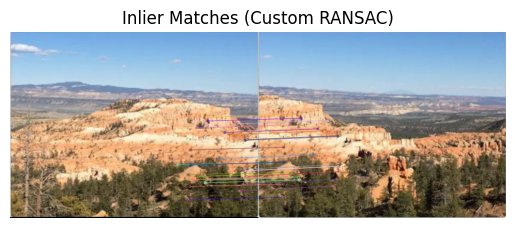

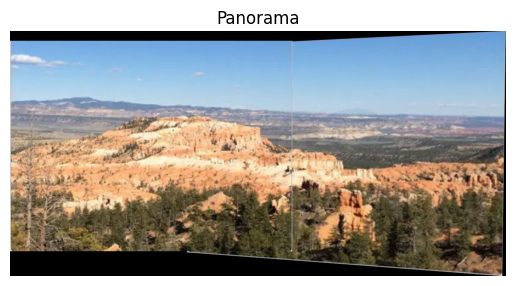

In [10]:
#IMG1_PATH = ROOT_DIR + 'B_original_image_left.jpg'   # change to your image 1
#IMG2_PATH = ROOT_DIR + 'B_original_image_right.jpg'  # change to your image 2

IMG1_PATH = '/kaggle/input/image-matching/algn_test1_A.png'   # change to your image 1
IMG2_PATH = '/kaggle/input/image-matching/algn_test1_B.png' 

img1 = cv2.imread(IMG1_PATH, cv2.IMREAD_COLOR)
img2 = cv2.imread(IMG2_PATH, cv2.IMREAD_COLOR)
if img1 is None or img2 is None:
    raise FileNotFoundError('Cannot open input images. Please set IMG1_PATH and IMG2_PATH correctly.')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect keypoints
kps1 = detect_keypoints_dog_harris(gray1)
kps2 = detect_keypoints_dog_harris(gray2)
print(f'Keypoints: img1={len(kps1)}, img2={len(kps2)}')
cv2.imwrite(str(OUT_DIR/'kps_img1.png'), draw_keypoints(img1, kps1))
cv2.imwrite(str(OUT_DIR/'kps_img2.png'), draw_keypoints(img2, kps2))

# ORB descriptors
kps1_cv, desc1 = compute_orb_descriptors(gray1, kps1)
kps2_cv, desc2 = compute_orb_descriptors(gray2, kps2)
if desc1 is None or desc2 is None:
    raise RuntimeError('No descriptors computed; try relaxing thresholds or pick more textured images.')

# Matching (ratio test)
good = match_descriptors(desc1, desc2, ratio=0.75)
print('Good matches:', len(good))
matches_all = cv2.drawMatches(img1, kps1_cv, img2, kps2_cv, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite(str(OUT_DIR/'matches_all.png'), matches_all)

# Custom Homography
H, inliers = estimate_homography_custom(kps1_cv, kps2_cv, good, ransac_thresh=3.0)
if H is None:
    raise RuntimeError('Custom homography estimation failed (not enough inliers).')
print('Homography (custom):\n', H)
inlier_matches = [m for m, keep in zip(good, inliers) if keep]
matches_inliers = cv2.drawMatches(img1, kps1_cv, img2, kps2_cv, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite(str(OUT_DIR/'matches_inliers.png'), matches_inliers)

# Warp & panorama
warped_img2, panorama = warp_and_stitch(img1, img2, H)
cv2.imwrite(str(OUT_DIR/'warped_img2.png'), warped_img2)
cv2.imwrite(str(OUT_DIR/'panorama.png'), panorama)

# Show quick previews
plt.figure(); plt.imshow(cv2.cvtColor(matches_inliers, cv2.COLOR_BGR2RGB)); plt.title('Inlier Matches (Custom RANSAC)'); plt.axis('off'); plt.show()
plt.figure(); plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)); plt.title('Panorama'); plt.axis('off'); plt.show()